In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import numpy as np
import talib.abstract as ta
# np.random.seed(314)
from indicatormix.util import normalize


In [2]:
import datetime
import requests_cache
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='req_cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

In [3]:
plt.rcParams["figure.figsize"] = [10, 7]

# Data Downloading

In [41]:
from lazyft.data_loader import load_pair_data
import pandas_datareader.data as web
from dateutil import parser

timerange = "20220101-"
# timerange = "20220101-"
dt = parser.parse(timerange.strip("-"))
interval = "1d"


def download_ticker(ticker: str, interval):
    import re
    d = web.get_data_yahoo(ticker, dt.strftime("%Y-%m-%d"), session=session,
                           interval=re.sub("\d", "", interval))
    print(d.columns)
    # make all columns names lowercase
    d.columns = [col.lower() for col in d.columns]
    d.index = pd.to_datetime(d.index, utc=True)
    return d


data = dict(
    btc=load_pair_data("BTC/USDT", interval, timerange=timerange),
    eth=load_pair_data("ETH/USDT", interval, timerange=timerange),
    # xrp=load_pair_data("XRP/USDT", interval, timerange=timerange),
    sol=load_pair_data("SOL/USDT", interval, timerange=timerange),
    # luna=load_pair_data("LUNA/USDT", interval, timerange=timerange),
    ksm=load_pair_data("KSM/USDT", interval, timerange=timerange),
    # link=load_pair_data("LINK/USDT", interval, timerange=timerange),
    # ada=load_pair_data("ADA/USDT", interval, timerange=timerange),
    # dot=load_pair_data("DOT/USDT", interval, timerange=timerange),
    # avax=load_pair_data("AVAX/USDT", interval, timerange=timerange),
    # matic=load_pair_data("MATIC/USDT", interval, timerange=timerange),
    # ftm=load_pair_data("FTM/USDT", interval, timerange=timerange),
    # doge=load_pair_data("DOGE/USDT", interval, timerange=timerange),
    spy=download_ticker("spy", interval),
    nasdaq=download_ticker("^IXIC", interval),
)

# set the index to be the date
for k, v in data.items():
    try:
        v.index = pd.to_datetime(v.date, utc=True)
    except:
        pass
# print heads
for k, v in data.items():
    print(k, v.head())

2022-03-21 21:29:53.710 | INFO     | lazyft.downloader:download_missing_historical_data:301 - Checking if download is needed for KSM/USDT @ 1d interval(s)
2022-03-21 21:29:53.713 | INFO     | lazyft.downloader:download:370 - Downloading 79 days worth of market data for KSM/USDT @ 1d ticker-interval(s)...
2022-03-21 21:29:59.265 | INFO     | lazyft.downloader:download_watcher:430 - Downloaded history for KSM/USDT @ 1d (1/1)
2022-03-21 21:29:59.539 | INFO     | lazyft.downloader:download_missing_historical_data:333 - Finished downloading data for 1 pairs @ 1d
2022-03-21 21:29:59.540 | SUCCESS  | lazyft.downloader:download_missing_historical_data:338 - Data is up to date
Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')
Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')
btc                                                date  open  high   low  close  \
date                                                                           
2

In [42]:
full = pd.concat([p["close"] for p in data.values()], axis=1, join="outer")

inner = pd.concat([p["close"] for p in data.values()], axis=1, join="inner")
full.columns = list(data.keys())
inner.columns = list(data.keys())
full = full.dropna()
print(full.head())
print(full.tail())

                            btc   eth     sol     ksm     spy  nasdaq
2022-01-03 00:00:00+00:00 46.4K 3.77K 170.150 290.000 477.710   15.8K
2022-01-04 00:00:00+00:00 45.8K 3.79K 167.720 295.600 477.550   15.6K
2022-01-05 00:00:00+00:00 43.5K 3.54K 154.520 266.900 468.380   15.1K
2022-01-06 00:00:00+00:00 43.1K 3.41K 150.260 269.600 467.940   15.1K
2022-01-07 00:00:00+00:00 41.6K  3.2K 136.450 250.800 466.090   14.9K
                            btc   eth    sol     ksm     spy  nasdaq
2022-03-14 00:00:00+00:00 39.7K 2.59K 81.220 120.400 417.000   12.6K
2022-03-15 00:00:00+00:00 39.3K 2.62K 82.840 125.600 426.170   12.9K
2022-03-16 00:00:00+00:00 41.1K 2.77K 87.770 130.700 435.620   13.4K
2022-03-17 00:00:00+00:00 40.9K 2.81K 87.800 133.000 441.070   13.6K
2022-03-18 00:00:00+00:00 41.8K 2.94K 89.800 148.300 444.520   13.9K


In [28]:
full

,eth,sol,link,ada,dot,avax,matic,ftm,spy,nasdaq
2020-09-22 00:00:00+00:00,344.210,2.908,8.740,0.081,4.162,5.319,0.020,0.045,330.300,11K
2020-09-23 00:00:00+00:00,320.720,2.855,7.636,0.077,4.008,3.535,0.018,0.035,322.640,10.6K
2020-09-24 00:00:00+00:00,348.970,3.143,9.870,0.083,4.378,4.641,0.019,0.040,323.500,10.7K
2020-09-25 00:00:00+00:00,351.920,3.194,10.728,0.097,4.414,4.713,0.019,0.042,328.730,10.9K
2020-09-28 00:00:00+00:00,353.960,2.960,10.283,0.100,4.450,4.202,0.019,0.039,334.190,11.1K
...,...,...,...,...,...,...,...,...,...,...
2022-03-14 00:00:00+00:00,2.59K,81.220,13.410,0.802,17.700,68.970,1.379,1.085,417.000,12.6K
2022-03-15 00:00:00+00:00,2.62K,82.840,13.690,0.800,17.810,69.820,1.378,1.197,426.170,12.9K
2022-03-16 00:00:00+00:00,2.77K,87.770,14.660,0.838,19.050,74.080,1.467,1.269,435.620,13.4K
2022-03-17 00:00:00+00:00,2.81K,87.800,14.400,0.835,18.750,79.400,1.446,1.204,441.070,13.6K


In [44]:
full_returns = full.pct_change(axis=0).dropna()
# full_returns[['eth', 'dot']]

<AxesSubplot:>

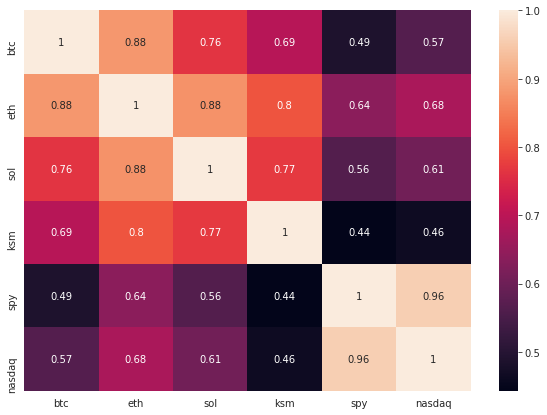

In [45]:
sns.heatmap(full_returns.corr(), annot=True)

<AxesSubplot:title={'center':'btc'}>

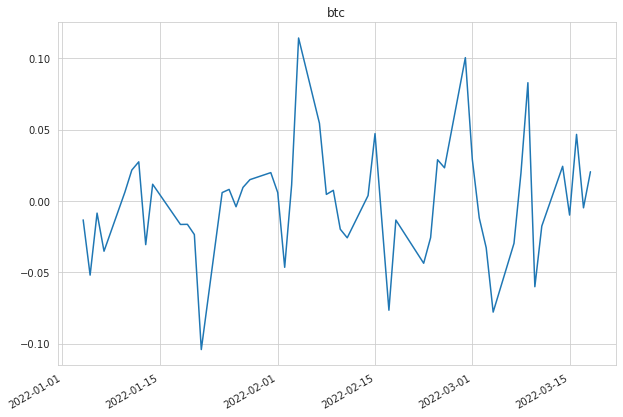

In [48]:
full_returns['btc'].plot(title='btc')

<AxesSubplot:title={'center':'ksm'}>

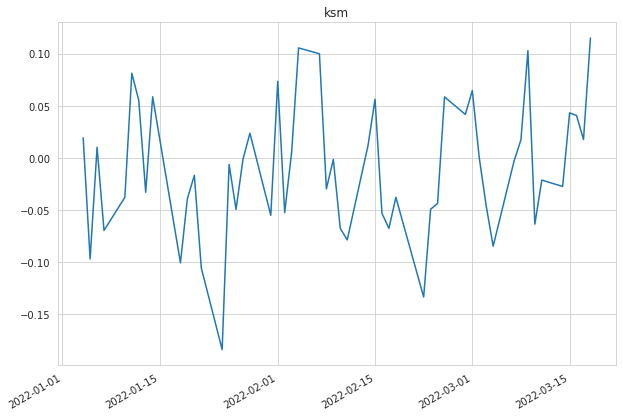

In [49]:
full_returns['ksm'].plot(title='ksm')

<AxesSubplot:title={'center':'BTC Daily Returns'}, xlabel='Date', ylabel='Returns'>

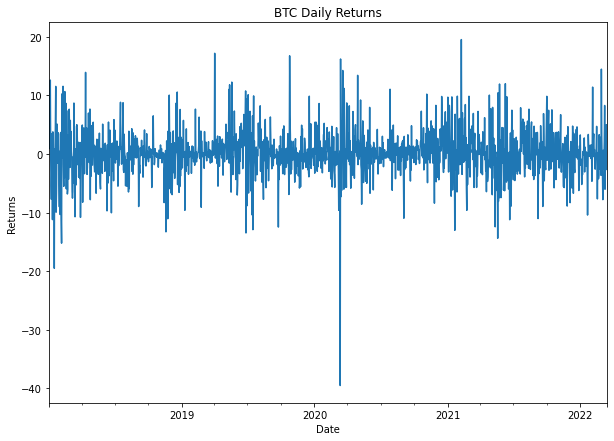

In [8]:
full["btc"].pct_change(axis=0).dropna().mul(100).plot(
    title="BTC Daily Returns", ylabel="Returns", xlabel="Date"
)

# Config

In [68]:
n_components = 5
market = 'btc'
sret = 'sret_'
timeperiod = 14
split_ratio = 0.5
ohlc = data[market]

# Preprocessing

In [75]:
from indicatormix.helpers.custom_indicators import heiken_ashi

new = pd.DataFrame(index=full[market].index)
new[market] = normalize(full[market])
# np.log(x/x.shift(1))
# new[f'wma-{timeperiod}'] = ta.WMA(new[market], timeperiod)
new[sret] = np.log(full[market] / full[market].shift(1))
# new[sret] = full[market].pct_change(axis=0).dropna()
# new[f'haclose_{7}'] = heiken_ashi(data[market], length=timeperiod)['close']
new[f'rsi_{timeperiod}'] = normalize(ta.RSI(data[market], timeperiod=timeperiod))
new[f'roc_{timeperiod}'] = normalize(ta.ROC(data[market], timeperiod=timeperiod))
# new[f'ad'] = normalize(ta.AD(data[market]))
# new[f'obv'] = normalize(ta.OBV(data[market]))
# new[f'rsi_{timeperiod}'] = (ta.RSI(data[market], timeperiod=timeperiod))
# new[f'roc_{timeperiod}'] = (ta.ROC(data[market], timeperiod=timeperiod))
# new[f'ad'] = (ta.AD(data[market]))
# new[f'obv'] = (ta.OBV(data[market]))
# new[f'cci_{timeperiod}'] = ta.CCI(ohlc['high'], ohlc['low'], ohlc['close'], timeperiod=timeperiod)
select = new.dropna()
# select = select.drop(columns=[market])
# print(new.tail())
print(select.head())
print(select.tail())
print(len(select))

                            btc  sret_  rsi_14  roc_14
date                                                  
2018-01-15 00:00:00+00:00 0.161  0.005   0.507   0.419
2018-01-16 00:00:00+00:00 0.120 -0.217   0.369   0.178
2018-01-17 00:00:00+00:00 0.121  0.008   0.374   0.172
2018-01-18 00:00:00+00:00 0.121 -0.002   0.373   0.165
2018-01-19 00:00:00+00:00 0.128  0.046   0.410   0.119
                            btc  sret_  rsi_14  roc_14
date                                                  
2022-03-12 00:00:00+00:00 0.553  0.002   0.449   0.401
2022-03-13 00:00:00+00:00 0.537 -0.027   0.416   0.410
2022-03-14 00:00:00+00:00 0.567  0.049   0.489   0.336
2022-03-15 00:00:00+00:00 0.561 -0.010   0.475   0.304
2022-03-16 00:00:00+00:00 0.589  0.046   0.541   0.351
1522


In [76]:
ft_cols = [col for col in select.columns if col not in ["date"]]

# split data into train and test
training_data = select.iloc[:int(len(select) * split_ratio)]
X1 = training_data[ft_cols].values

test_data = select.iloc[int(len(select) * split_ratio):]
X2 = test_data[ft_cols].values

print(training_data.head())
print(test_data.head())

                            btc  sret_  rsi_14  roc_14
date                                                  
2018-01-15 00:00:00+00:00 0.161  0.005   0.507   0.419
2018-01-16 00:00:00+00:00 0.120 -0.217   0.369   0.178
2018-01-17 00:00:00+00:00 0.121  0.008   0.374   0.172
2018-01-18 00:00:00+00:00 0.121 -0.002   0.373   0.165
2018-01-19 00:00:00+00:00 0.128  0.046   0.410   0.119
                            btc  sret_  rsi_14  roc_14
date                                                  
2020-02-15 00:00:00+00:00 0.104 -0.043   0.606   0.458
2020-02-16 00:00:00+00:00 0.104  0.001   0.609   0.464
2020-02-17 00:00:00+00:00 0.101 -0.022   0.546   0.448
2020-02-18 00:00:00+00:00 0.108  0.046   0.642   0.502
2020-02-19 00:00:00+00:00 0.099 -0.058   0.502   0.406


In [77]:

print(ft_cols)

['btc', 'sret_', 'rsi_14', 'roc_14']


# Training/Testing

In [78]:
model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=5000000, implementation='scaling')
model.fit(X1)
# z = model.predict(data_temp)

GaussianHMM(covariance_type='full', implementation='scaling', n_components=5,
            n_iter=5000000)

In [79]:
hidden_states = model.predict(X2)

# Display

                       date  state   btc  sret_  rsi_14  roc_14  mkt_cret
0 2020-02-15 00:00:00+00:00      4 0.104 -0.043   0.606   0.458    -0.043
1 2020-02-16 00:00:00+00:00      2 0.104  0.001   0.609   0.464    -0.042
2 2020-02-17 00:00:00+00:00      3 0.101 -0.022   0.546   0.448    -0.064
3 2020-02-18 00:00:00+00:00      3 0.108  0.046   0.642   0.502    -0.018
4 2020-02-19 00:00:00+00:00      3 0.099 -0.058   0.502   0.406    -0.075


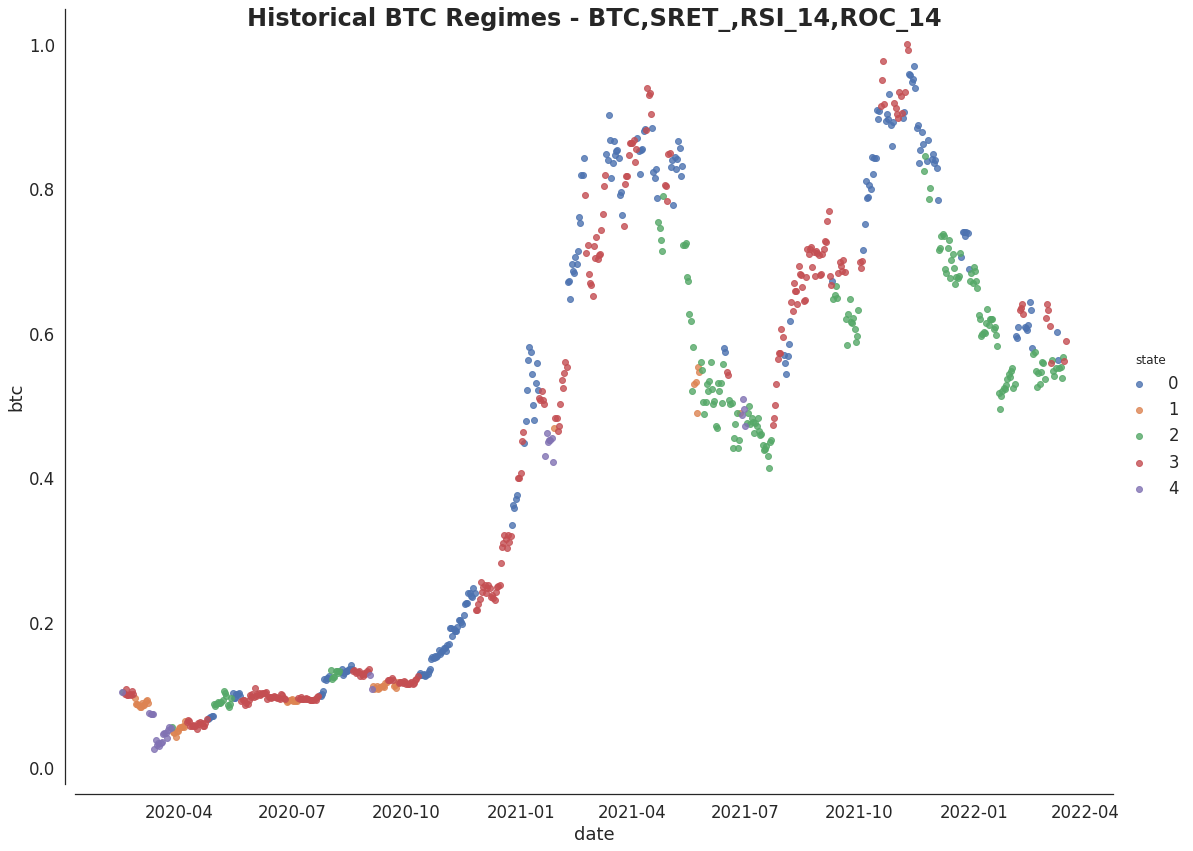

In [81]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['state'], index=test_data.index)
          .join(select, how='inner')
          .assign(mkt_cret=test_data[sret].cumsum())
          .reset_index(drop=False)
          .rename(columns={'index': 'date'}))
if market not in states.columns:
    print('adding btc to states')
    copy = full[states.iloc[0]['date']:]
    copy.index = states.index
    states[market] = copy[market]
print(states.head())
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3, 'legend.frameon': True}
sns.set_style('white', style_kwds)
order = list(range(n_components))
fg = sns.FacetGrid(data=states, hue='state', hue_order=order,
                   aspect=1.31, height=12)
fg.map(plt.scatter, 'date', market, alpha=0.8).add_legend()
# fg.map(plt.plot, data=states[market]).add_legend()
sns.despine(offset=10)
fg.fig.suptitle(f'Historical {market.upper()} Regimes - {",".join([f.upper() for f in ft_cols])}', fontsize=24,
                fontweight='demi')
fg.savefig(f'hmm/images/HMM-{"_".join(ft_cols)}-{n_components}c.png')



In [80]:
states['states'].describe()

count   1.17K
mean    0.651
std     0.825
min     0.000
25%     0.000
50%     0.000
75%     1.000
max     2.000
Name: states, dtype: float64

In [23]:
import mpu

mpu.io.write('data/models/btc_hmm.pickle', model)

GaussianHMM(covariance_type='full', n_components=2, n_iter=100)

In [228]:
def predict_regimes(data, model) -> pd.DataFrame:
    # df = data.pct_change(axis=0).dropna().mul(100)
    # df_temp = df.values.reshape(-1, 1)
    z = model.predict(X2)

    unique, counts = np.unique(z, return_counts=True)
    z_dict = dict(zip(unique, counts))

    df2 = test_data.copy()
    df2["Regime"] = z
    if z_dict[1] > z_dict[0]:
        df2["Regime"][df2["Regime"] == 1] = 2  # temp
        df2["Regime"][df2["Regime"] == 0] = 1
        df2["Regime"][df2["Regime"] == 2] = 0

    return df2

In [229]:
def calc_posterior(data, model):
    df = data.pct_change(axis=0).dropna().mul(100)
    df_temp = df.values.reshape(-1, 1)
    post = model.predict_proba(df_temp)

    return post

In [230]:
def calc_stats(df):
    stats = {}
    keys = df["Regime"].unique()

    for key in keys:
        stats[key] = [
            df[df["Regime"] == key].iloc[:, 0].mean(),
            df[df["Regime"] == key].iloc[:, 0].std(),
        ]

    stats = pd.DataFrame(stats, index=["Mean", "SD"])

    return stats

In [231]:
pd.options.mode.chained_assignment = None
# predict_range = full['2022-01-01':]["btc"]
predict_range = full["btc"]
sp = predict_regimes(training_data, model)
# rut = predict_regimes(full["Russell"],model)
# nas = predict_regimes(full["Nasdaq"],model)
# dow = predict_regimes(full["Dow"],model)
# sp_post = calc_posterior(predict_range, model)
# rut_post = calc_posterior(full["Russell"],model)
# nas_post = calc_posterior(full["Nasdaq"],model)
# dow_post = calc_posterior(full["Dow"],model)

In [232]:
print(sp.tail())
print(full.tail())
print(sp['Regime'].unique())

                            btc  sret_  rsi_14  roc_14  Regime
date                                                          
2022-03-12 00:00:00+00:00 0.553  0.002   0.449   0.401       0
2022-03-13 00:00:00+00:00 0.537 -0.027   0.416   0.410       0
2022-03-14 00:00:00+00:00 0.567  0.050   0.489   0.336       0
2022-03-15 00:00:00+00:00 0.561 -0.010   0.475   0.304       0
2022-03-16 00:00:00+00:00 0.589  0.047   0.541   0.351       0
                            btc
date                           
2022-03-12 00:00:00+00:00 38.8K
2022-03-13 00:00:00+00:00 37.8K
2022-03-14 00:00:00+00:00 39.7K
2022-03-15 00:00:00+00:00 39.3K
2022-03-16 00:00:00+00:00 41.1K
[1 0 4 3]


                           Regime   btc
date                                   
2020-02-15 00:00:00+00:00       1  9.9K
2020-02-16 00:00:00+00:00       0 9.92K
2020-02-17 00:00:00+00:00       0 9.71K
2020-02-18 00:00:00+00:00       0 10.2K
2020-02-19 00:00:00+00:00       0 9.59K


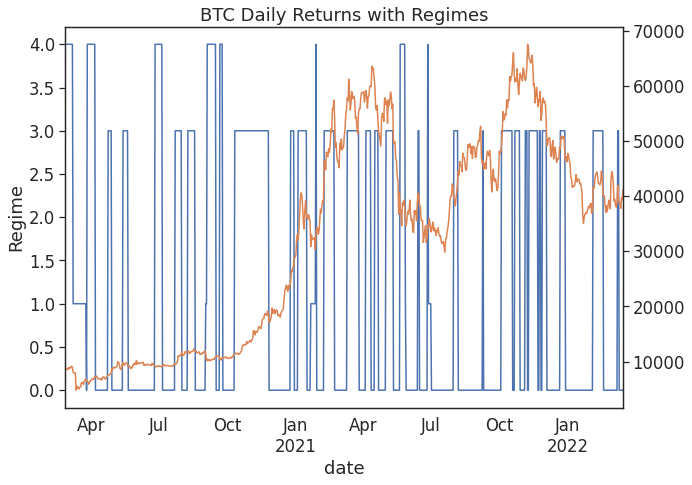

In [238]:
cp = test_data.copy()
cp[market] = full[market]
cp["Regime"] = sp["Regime"]
cp = cp[["Regime", market]]
print(cp.head())
cp.iloc[-750:, 0].plot(
    title="BTC Daily Returns with Regimes", label="btc", ylabel="btc"
)
cp.iloc[-750:, 1].plot(secondary_y=True, ylabel="Regime")

plt.show()

In [74]:
sp['btc'].min()

-39.50484717412017

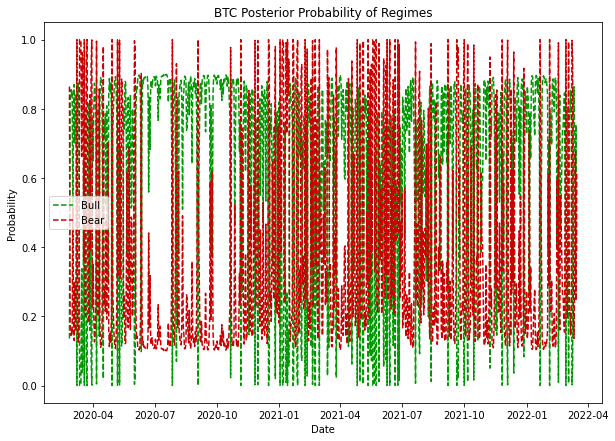

In [75]:
# Plot two lines of varying colors
plt.plot(
    sp.index[-750:],
    sp_post[-750:, 0],
    color="#009901",
    linestyle="dashed",
    label="Bull",
)
plt.plot(
    sp.index[-750:],
    sp_post[-750:, 1],
    color="#cb0000",
    linestyle="dashed",
    label="Bear",
)

# Add labels
plt.legend(loc="center left")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.title("BTC Posterior Probability of Regimes")
plt.show()

In [ ]:
rut.iloc[-750:, 0].plot(
    title="Russell 2000 Daily Returns with Regimes", label="Returns", ylabel="Returns"
)
rut.iloc[-750:, 1].plot(secondary_y=True, ylabel="Regime")
plt.show()

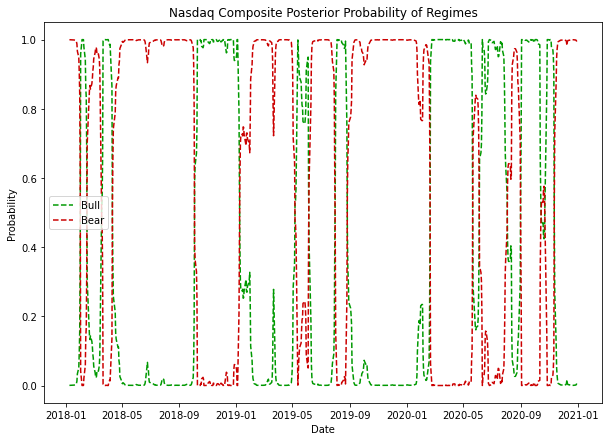

In [19]:
# Plot two lines of varying colors
plt.plot(
    nas.index[-750:],
    nas_post[-750:, 0],
    color="#009901",
    linestyle="dashed",
    label="Bull",
)
plt.plot(
    nas.index[-750:],
    nas_post[-750:, 1],
    color="#cb0000",
    linestyle="dashed",
    label="Bear",
)

# Add labels
plt.legend(loc="center left")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.title("Nasdaq Composite Posterior Probability of Regimes")
plt.show()

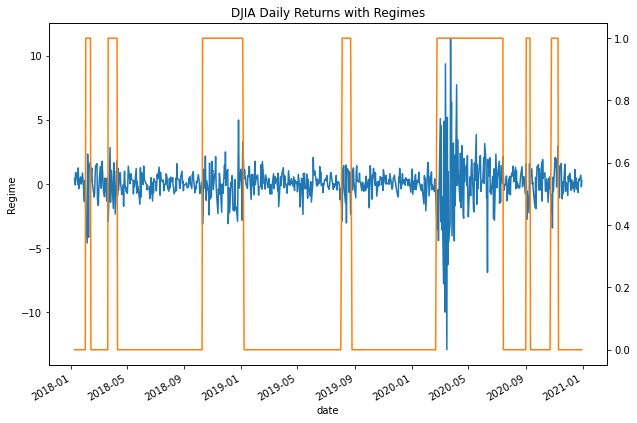

In [20]:
dow.iloc[-750:, 0].plot(
    title="DJIA Daily Returns with Regimes", label="Returns", ylabel="Returns"
)
dow.iloc[-750:, 1].plot(secondary_y=True, ylabel="Regime")
plt.show()

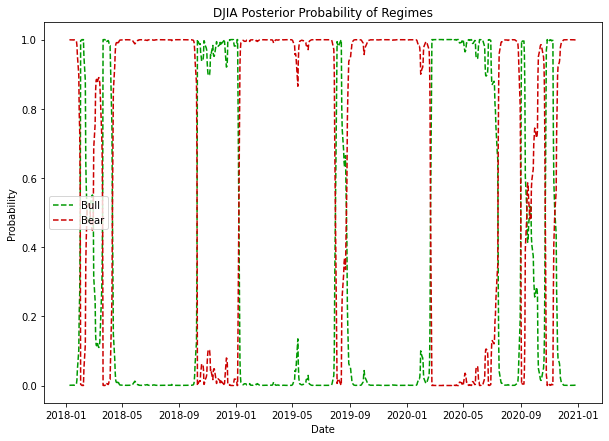

In [21]:
# Plot two lines of varying colors
plt.plot(
    dow.index[-750:],
    dow_post[-750:, 0],
    color="#009901",
    linestyle="dashed",
    label="Bull",
)
plt.plot(
    dow.index[-750:],
    dow_post[-750:, 1],
    color="#cb0000",
    linestyle="dashed",
    label="Bear",
)

# Add labels
plt.legend(loc="center left")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.title("DJIA Posterior Probability of Regimes")
plt.show()

In [22]:
calc_stats(sp)

,0,1
Mean,0.061666,-0.095192
SD,0.707415,2.268218


In [23]:
calc_stats(rut)

,0,1
Mean,0.090900,-0.068717
SD,0.729725,2.093932


In [24]:
calc_stats(nas)

,0,1
Mean,0.092760,-0.089833
SD,0.703041,2.168242


In [25]:
calc_stats(dow)

,0,1
Mean,0.064800,-0.073787
SD,0.719282,2.061603
